# 3. 消費者の市場反応モデル

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 3.2 線形回帰モデルを用いた市場反応分析

### データを概観する

In [4]:
# 朝倉書店のサイトからデータをダウンロードし、R_Appendixディレクトリに展開
# https://www.asakura.co.jp/books/isbn/978-4-254-12853-6/
data1 = pd.read_csv('./R_Appendix/sec3_reg.csv')

data1.head()

,Date,LogPI_A,LogPriceIndex_A,LogPriceIndex_B,Display_A,Display_B
0,20000102,0.022246,0.0,-0.127213,0,0
1,20000103,0.181522,0.0,-0.127213,0,0
2,20000104,-1.344691,0.0,-0.127213,0,0
3,20000105,-0.481191,0.0,-0.127213,0,0
4,20000106,0.203341,0.0,-0.127213,0,0


In [5]:
data1.describe()

,Date,LogPI_A,LogPriceIndex_A,LogPriceIndex_B,Display_A,Display_B
count,1.314000e+03,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,2.001454e+07,0.461188,-0.109652,-0.168167,0.083714,0.210046
std,1.063250e+04,1.063511,0.119585,0.176934,0.277064,0.407496
min,2.000010e+07,-1.629241,-1.063218,-1.144398,0.000000,0.000000
25%,2.000122e+07,-0.207621,-0.176704,-0.222007,0.000000,0.000000
50%,2.001111e+07,0.479017,-0.135545,-0.127213,0.000000,0.000000
75%,2.002101e+07,1.192025,0.000000,0.000000,0.000000,0.000000
max,2.003090e+07,5.005715,0.000000,0.000000,1.000000,1.000000


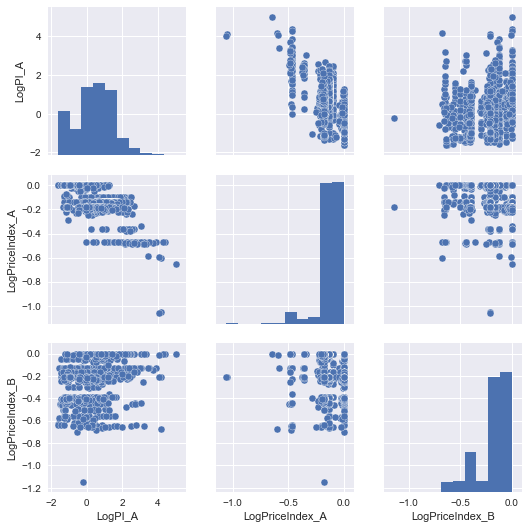

In [6]:
sns.pairplot(data1[['LogPI_A', 'LogPriceIndex_A', 'LogPriceIndex_B']])

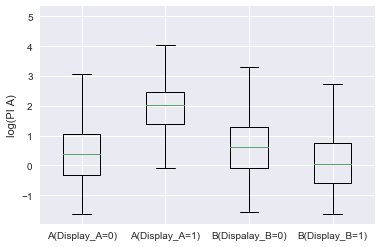

In [7]:
plt.boxplot([data1[data1['Display_A'] == 0]['LogPI_A'], 
             data1[data1['Display_A'] == 1]['LogPI_A'],
             data1[data1['Display_B'] == 0]['LogPI_A'], 
             data1[data1['Display_B'] == 1]['LogPI_A']],
            labels=['A(Display_A=0)', 'A(Display_A=1)', 'B(Dispalay_B=0)', 'B(Display_B=1)'])
plt.ylabel('log(PI A)')

### t検定で醤油Bの山積み陳列の効果を確認

In [8]:
from scipy import stats

treatment_A = data1[(data1['Display_A'] == 0) & (data1['Display_B'] == 1)]['LogPI_A']
print('[商品Bの山積み陳列有り(Display_B=1)]')
print('標本数:', len(treatment_A))
print('標本平均(log(PI A)):', treatment_A.mean())
print('標本分散(log(PI A)):', treatment_A.var(ddof=0))

lower_mu_treatment_A = treatment_A.mean() - (stats.t.ppf(0.975, len(treatment_A) - 1) * (treatment_A.var() / math.sqrt(len(treatment_A))))
upper_mu_treatment_A = treatment_A.mean() + (stats.t.ppf(0.975, len(treatment_A) - 1) * (treatment_A.var() / math.sqrt(len(treatment_A))))
print('母平均の95%信頼区間: [{},{}]'.format(lower_mu_treatment_A, upper_mu_treatment_A))

control_A = data1[(data1['Display_A'] == 0) & (data1['Display_B'] == 0)]['LogPI_A']
print('[商品Bの山積み陳列無し(Display_B=0)]')
print('標本数:', len(control_A))
print('標本平均(log(PI A)):', control_A.mean())
print('標本分散(log(PI A)):', control_A.var(ddof=0))

lower_mu_control_A = control_A.mean() - (stats.t.ppf(0.975, len(control_A) - 1) * (control_A.var() / math.sqrt(len(control_A))))
upper_mu_control_A = control_A.mean() + (stats.t.ppf(0.975, len(control_A) - 1) * (control_A.var() / math.sqrt(len(control_A))))
print('母平均の95%信頼区間: [{},{}]'.format(lower_mu_control_A, upper_mu_control_A))

[商品Bの山積み陳列有り(Display_B=1)]
標本数: 256
標本平均(log(PI A)): -0.05027621526171866
標本分散(log(PI A)): 0.7651368638646278
母平均の95%信頼区間: [-0.14482003414108333,0.044267603617646006]
[商品Bの山積み陳列無し(Display_B=0)]
標本数: 948
標本平均(log(PI A)): 0.42754264879430337
標本分散(log(PI A)): 0.9095721262593743
母平均の95%信頼区間: [0.36950700051744356,0.4855782970711632]


In [9]:
# 母分散が異なるため、ウェルチのt検定で平均の差を検定(左片側検定)
m = len(treatment_A)
n = len(control_A)
s_1 = treatment_A.var()
s_0 = control_A.var()

t = (treatment_A.mean() - control_A.mean()) / math.sqrt(s_1**2 / m + s_0**2 / n)
print('t:', t)

# 自由度νを近似的に計算
nu = (s_1 ** 2 / m + s_0**2 / n)**2 / ((s_1**2 / m)**2 / (m-1) + (s_0**2 / n)**2 / (n-1))
nu_star = round(nu) # 整数ν*に丸める

print('-t_0.95(ν*):', -stats.t.ppf(0.95, nu_star))

t: -8.47408316482311
-t_0.95(ν*): -1.648123037613254


### 線形回帰でモデル化

In [11]:
import statsmodels.api as sm

model = sm.OLS(data1['LogPI_A'],
               sm.add_constant(data1[['LogPriceIndex_A', 'LogPriceIndex_B', 'Display_A', 'Display_B']]))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LogPI_A   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     457.7
Date:                Sat, 24 Mar 2018   Prob (F-statistic):          7.99e-247
Time:                        22:12:36   Log-Likelihood:                -1370.1
No. Observations:                1314   AIC:                             2750.
Df Residuals:                    1309   BIC:                             2776.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1628      0.033      4.929      0.000       0.098       0.228
LogPriceIndex_A    -5.0202      0.175    -28.746      0.000      -5.363      -4.678
LogPriceIndex_B     1.9314      0.142     13.577      0.000       1.652       2.210
Display_A           0.7744      0.074     10.460      0.000       0.629       0.920
Display_B           0.0374      0.062      0.607      0.544      -0.084       0.158
==============================================================================
Omnibus:                       41.503   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.669
Skew:                          -0.405   Prob(JB):                     8.95e-10
Kurtosis:                       2.676   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
data1.corr()

,Date,LogPI_A,LogPriceIndex_A,LogPriceIndex_B,Display_A,Display_B
Date,1.000000,-0.222519,-0.148485,-0.199656,-0.075330,0.098323
LogPI_A,-0.222519,1.000000,-0.673244,0.374919,0.420873,-0.162737
LogPriceIndex_A,-0.148485,-0.673244,1.000000,-0.101486,-0.373283,-0.058444
LogPriceIndex_B,-0.199656,0.374919,-0.101486,1.000000,0.027150,-0.640540
Display_A,-0.075330,0.420873,-0.373283,0.027150,1.000000,-0.020946
Display_B,0.098323,-0.162737,-0.058444,-0.640540,-0.020946,1.000000


## 3.3 ポアソン回帰モデルを用いた市場反応分析

### データを概観する

In [13]:
data2 = pd.read_csv('./R_Appendix/sec3_poisson_reg.csv')

data2.head()

,Date,Sale_Unit_A,PriceIndex_A,PriceIndex_B,Display_A,Display_B,Visitors
0,20000102,3,1.0,0.880546,0,0,2934
1,20000103,4,1.0,0.880546,0,0,3336
2,20000104,1,1.0,0.880546,0,0,3837
3,20000105,2,1.0,0.880546,0,0,3236
4,20000106,4,1.0,0.880546,0,0,3264


In [14]:
data2.describe()

,Date,Sale_Unit_A,PriceIndex_A,PriceIndex_B,Display_A,Display_B,Visitors
count,1.314000e+03,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,2.001454e+07,11.130898,0.902124,0.857701,0.083714,0.210046,3530.617199
std,1.063250e+04,28.669845,0.097840,0.138471,0.277064,0.407496,572.282375
min,2.000010e+07,1.000000,0.345343,0.318415,0.000000,0.000000,1955.000000
25%,2.000122e+07,3.000000,0.838028,0.800910,0.000000,0.000000,3129.000000
50%,2.001111e+07,6.000000,0.873239,0.880546,0.000000,0.000000,3396.500000
75%,2.002101e+07,11.000000,1.000000,1.000000,0.000000,0.000000,3836.000000
max,2.003090e+07,669.000000,1.000000,1.000000,1.000000,1.000000,7351.000000


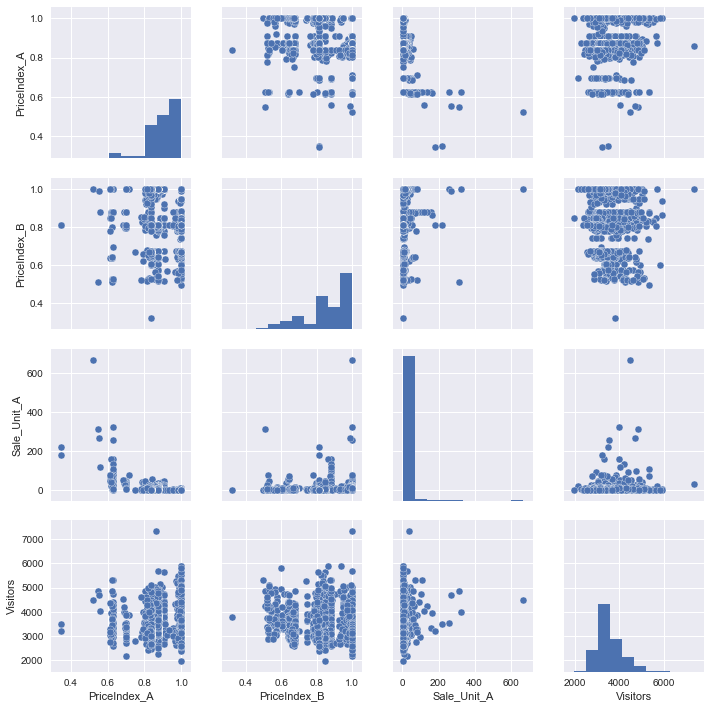

In [15]:
sns.pairplot(data2[['PriceIndex_A', 'PriceIndex_B', 'Sale_Unit_A', 'Visitors']])

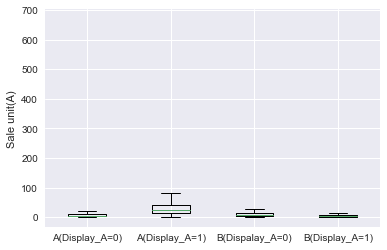

In [16]:
plt.boxplot([data2[data2['Display_A'] == 0]['Sale_Unit_A'], 
             data2[data2['Display_A'] == 1]['Sale_Unit_A'],
             data2[data2['Display_B'] == 0]['Sale_Unit_A'], 
             data2[data2['Display_B'] == 1]['Sale_Unit_A']],
            labels=['A(Display_A=0)', 'A(Display_A=1)', 'B(Dispalay_A=0)', 'B(Display_A=1)'])
plt.ylabel('Sale unit(A)')

### ポアソン回帰でモデル化

In [19]:
import statsmodels.formula.api as smf

# オフセット有り
model = smf.glm('Sale_Unit_A ~ PriceIndex_A + PriceIndex_B + Display_A + Display_B',
                data=data2,
                offset=np.log(data2['Visitors']),
                family=sm.families.Poisson(link=sm.families.links.log))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Sale_Unit_A   No. Observations:                 1314
Model:                            GLM   Df Residuals:                     1309
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -4867.0
Date:                Sat, 24 Mar 2018   Deviance:                       5005.7
Time:                        22:14:25   Pearson chi2:                 5.18e+03
No. Iterations:                     5                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.9287      0.102    -18.845      0.000      -2.129      -1.728
PriceIndex_A    -6.9057      0.061   -113.103      0.000      -7.025      -6.786
PriceIndex_B     2.1294      0.089     23.859      0.000       1.954       2.304
Display_A        0.8409      0.019     43.752      0.000       0.803       0.879
Display_B       -0.0618      0.031     -2.024      0.043      -0.122      -0.002
================================================================================
"""

In [20]:
# オフセット無し
model = smf.glm('Sale_Unit_A ~ PriceIndex_A + PriceIndex_B + Display_A + Display_B',
                data=data2,
                family=sm.families.Poisson(link=sm.families.links.log))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Sale_Unit_A   No. Observations:                 1314
Model:                            GLM   Df Residuals:                     1309
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -5458.2
Date:                Sat, 24 Mar 2018   Deviance:                       6188.0
Time:                        22:14:42   Pearson chi2:                 6.69e+03
No. Iterations:                     5                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.3593      0.104     61.412      0.000       6.156       6.562
PriceIndex_A    -6.9617      0.061   -113.240      0.000      -7.082      -6.841
PriceIndex_B     2.0440      0.090     22.778      0.000       1.868       2.220
Display_A        0.8554      0.019     44.476      0.000       0.818       0.893
Display_B       -0.0709      0.031     -2.308      0.021      -0.131      -0.011
================================================================================
"""